## World Bank income groups<a name="worldbank"></a>
Determine the number of active OJS journals by country, then group countries by income using World Bank GNI data*:
https://datahelpdesk.worldbank.org/knowledgebase/articles/906519-world-bank-country-and-lending-groups <br>
*GNI data is updated as of FY22 but reflects 2020 data

Rename the beaconActive DataFrame's 'country_consolidated' variable as 'tld' (top-level domain):

In [71]:
beaconActive.rename(columns={'country_consolidated':'tld'}, inplace=True)

#### Preprocess the World Bank country and lending group dataset (12/2021):

In [72]:
wbGroups = pd.read_excel('data/wb_tlds.xlsx')

In [73]:
#Select only the country, income_group, and tld variables, and rename them accordingly:
wbGroups = wbGroups[['Economy',
                       'Income group',
                       'Domain']]
wbGroups.rename(columns={'Economy':'country','Income group':'income_group','Domain':'tld'}, inplace=True)

In [74]:
wbGroups.isnull().sum()

country         0
income_group    0
tld             1
dtype: int64

In [75]:
#There is one missing 'tld' value
wbGroups[wbGroups['tld'].isnull()]

,country,income_group,tld
141,Namibia,Upper middle income,NaN


In [76]:
#Namibia is missing! The top-level domain 'NA' read into pandas as NaN
#Change NaN to NA in the 'tld' column for both DataFrames
wbGroups['tld'] = np.where(wbGroups['tld'].isnull(), 'NA', wbGroups['tld'])
beaconActive['tld'] = np.where(beaconActive['oai_url'].str.contains('.na/'), 'NA', beaconActive['tld'])

In [77]:
#Filter the World Bank income class dataset to include only those countries that match beaconActive:
wbGroups = wbGroups[wbGroups['tld'].isin(beaconActive['tld'])].reset_index()
wbGroups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   index         139 non-null    int64 
 1   country       139 non-null    object
 2   income_group  139 non-null    object
 3   tld           139 non-null    object
dtypes: int64(1), object(3)
memory usage: 4.5+ KB


In [78]:
#Check for duplicates in the 'tld' column 
wbGroups[wbGroups['tld'].duplicated()]

,index,country,income_group,tld
134,216,Kosovo,Upper middle income,AL


In [79]:
#Kosovo shares a top-level domain with Albania. But both Kosovo and Albania belong to the same income_group
#Merging on 'tld', so delete Kosovo for now
wbGroups.drop(index=134, inplace=True)

In [80]:
#Drop the index column
wbGroups.drop('index', axis=1, inplace=True)
for group in wbGroups['income_group'].unique():
    print(group)

Low income
Lower middle income
Upper middle income
High income
Unclassified


Change Venezuela's income classification from 'Unclassified' (2021) to its previous classification (2020):

In [81]:
wbGroups['income_group'] = np.where(wbGroups['income_group'].str.contains('Unclassified'),
                                    'Upper middle income',
                                    wbGroups['income_group'])

#### Merge the Beacon and World Bank datasets by Top-Level Domain

In [82]:
incomeGroups = beaconActive.merge(wbGroups, how='inner', on='tld')

In [83]:
#91 rows (25742 - 25651) contain empty 'tld' values, so those have been dropped
incomeGroups.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25651 entries, 0 to 25650
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   oai_url       25651 non-null  object
 1   set_spec      25651 non-null  object
 2   context_name  25651 non-null  object
 3   issn          22832 non-null  object
 4   tld           25651 non-null  object
 5   issn_1        22832 non-null  object
 6   issn_2        8419 non-null   object
 7   journal_url   25651 non-null  object
 8   country       25651 non-null  object
 9   income_group  25651 non-null  object
dtypes: object(10)
memory usage: 2.2+ MB


In [84]:
incomeGroups.isnull().sum()

oai_url             0
set_spec            0
context_name        0
issn             2819
tld                 0
issn_1           2819
issn_2          17232
journal_url         0
country             0
income_group        0
dtype: int64

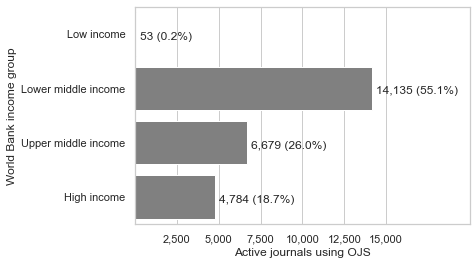

In [85]:
#Plot the distribution of OJS journals by World Bank income group
sns.set_theme(style='whitegrid')
sns.set_color_codes()
inc = sns.countplot(y='income_group', 
                    order=['Low income',
                           'Lower middle income',
                           'Upper middle income',
                           'High income'],
                    data=incomeGroups,
                    color='grey')


matplotlib.pyplot.xlim(0,20000)

matplotlib.pyplot.xticks([2500, 5000, 7500, 10000, 12500, 15000],
                         ['2,500', '5,000', '7,500', '10,000', '12,500', '15,000'])

for p in inc.patches:
    _x = p.get_x() + p.get_width()
    _y = p.get_y() + p.get_height() - 0.3
    value = '{:,}'.format(p.get_width())
    percent = round(((p.get_width() / 25651) * 100), 1)
    value = value + ' ({})'.format(str(percent)+'%')
    inc.text(_x + 250, _y, value, ha='left')

inc.set(xlabel='Active journals using OJS', ylabel='World Bank income group')
inc.figure.savefig('OJS_income_groups.png', bbox_inches='tight')